In [1]:
## Bring in needed mods
import numpy as np, pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
## list path and load with pd
fastq_path = '../../NOTES/fastq_files.txt'

## Set path to reference on big duck
refpath = '/analysis/CROTH/REF/FungiDB-46_CneoformansH99_Genome.fasta'

## set data path
datapath = '/data/sequence-data/Crypto_Bt22xFtc555_Oct2020/'

## set sam path 
sampath = '/analysis/CROTH/SAM/'

## set bam path
bampath = '/analysis/CROTH/BAM/'

## set bamaddrg path
addrgpath = '/home/croth/bin/./bamaddrg -b'

## set command
command = 'bwa mem -a -M %s %s %s | samtools view -F 4 -b | samtools sort -o %s'

## add parental PMY numbers
parentals = [
            'PMY2649',#Bt22
            'PMY2650',#Ftc555-1
            ]

In [3]:
## Gather fastq file size
sizes = pd.DataFrame([ int(a.split('pmagwene pmagwene')[-1].split('Oct')[0]) 
         for a in open(fastq_path,'r').readlines()],columns=['Filesize'])

In [4]:
## Gather fastq files
fastqs = ['PMY2'+a.split('PMY2')[-1][:-1] for a in open(fastq_path,'r').readlines()]
len(fastqs)

1536

In [5]:
## Append fastq names as column
sizes['Filename'] = fastqs

In [6]:
## gather sample names
sizes['Sample'] = [a.split('_R')[0] for a in fastqs]

## Gather unique sample name
samples = sizes.Sample.unique()
len(samples)

768

In [7]:
## Gather mean size of paired fastq files
meansize = sizes.groupby('Sample').agg(np.mean).reset_index().sort_values('Filesize')

## Add in pmy numbers
meansize['PMY'] = [s.split('_')[0] for s in meansize.Sample]

## Gather ordered index without parents
order_index = meansize[~(meansize.PMY.isin(parentals))].index.values

## View first few rows
meansize.head()

,Sample,Filesize,PMY
371,PMY2741_S145_L002,265780.0,PMY2741
370,PMY2741_S145_L001,269441.0,PMY2741
88,PMY2600_S298_L001,2398342.5,PMY2600
89,PMY2600_S298_L002,3232604.0,PMY2600
546,PMY2829_S70_L001,5305713.0,PMY2829


In [8]:
## check work, 2x samples should be length of fastq
assert len(samples)*2 == len(fastqs)

In [9]:
## gather sample ends 
ends = np.unique([a.split('_R')[-1] for a in fastqs])

## Check work paired end so should be 2
assert len(ends) == 2

In [10]:
## make bam paths
bams = [sampath+s+'-sm.bam' for s in samples]

## check work
assert len(np.unique(bams)) == len(samples)

In [11]:
## construct bam commands and take them ordred by size
bwa = np.array([command%(refpath,datapath+f+'_R'+ends[0],
                         datapath+f+'_R'+ends[1],bams[i]+'\n\n') 
                for i,f in enumerate(samples)])

In [12]:
## Take progeny bwa commands
progeny = bwa[order_index]

In [13]:
## view first command
bwa[0]

'bwa mem -a -M /analysis/CROTH/REF/FungiDB-46_CneoformansH99_Genome.fasta /data/sequence-data/Crypto_Bt22xFtc555_Oct2020/PMY2556_S193_L001_R1_001.fastq.gz /data/sequence-data/Crypto_Bt22xFtc555_Oct2020/PMY2556_S193_L001_R2_001.fastq.gz | samtools view -F 4 -b | samtools sort -o /analysis/CROTH/SAM/PMY2556_S193_L001-sm.bam\n\n'

In [14]:
len(samples)

768

In [15]:
## Check work
assert len(progeny) + 2*len(parentals) == len(samples)

In [16]:
## Split progeny samples across 4 files
nfiles = 4

filenames = '../BWA/run%s_bwa.sh'
for i in range(nfiles):
    filename = filenames%i
    
    open(filename,'w').writelines(progeny[i::nfiles])

In [17]:
## View parental info
parent_df = meansize[(meansize.PMY.isin(parentals))]
parent_df

,Sample,Filesize,PMY
186,PMY2649_S112_L001,36681346.5,PMY2649
187,PMY2649_S112_L002,37464615.5,PMY2649
188,PMY2650_S113_L001,40017758.0,PMY2650
189,PMY2650_S113_L002,40693413.0,PMY2650


In [18]:
## What is the mean file size?
meansize.Filesize.mean()

89646195.71289062

In [19]:
## gather parental bwa commands
parents_index = parent_df.index.values

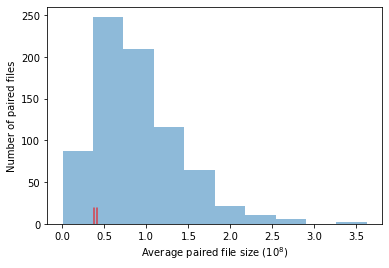

In [20]:
## Find were the parental file sizes fall into the bunch
plt.hist(meansize.Filesize.values/10**8,alpha=0.5);
plt.vlines(parent_df.Filesize.values/10**8,0,20,
           color='r',alpha=0.5,linewidth=1);
plt.ylabel('Number of paired files')
plt.xlabel('Average paired file size ($10^8$)');

In [21]:
## Wrtie parental bwa commands
open('../BWA/run_parents_bwa.sh','w').writelines(bwa[parents_index])

In [22]:
## Write merged bam files
merged_bams = np.unique([bampath+s.split('_L00')[0]+'.bam' for s in samples])

In [23]:
## Gather the sam file names
sams = np.unique([b.split('_L00')[0] for b in bams])

In [24]:
## Write merge commands
merged = ['samtools merge %s %s %s\n\n'%(
    merged_bams[i] ,s+'_L001-sm.bam',s+'_L002-sm.bam') 
          for i,s in enumerate(sams)]

In [25]:
## View first few commands
merged[:5]

['samtools merge /analysis/CROTH/BAM/PMY2556_S193.bam /analysis/CROTH/SAM/PMY2556_S193_L001-sm.bam /analysis/CROTH/SAM/PMY2556_S193_L002-sm.bam\n\n',
 'samtools merge /analysis/CROTH/BAM/PMY2557_S194.bam /analysis/CROTH/SAM/PMY2557_S194_L001-sm.bam /analysis/CROTH/SAM/PMY2557_S194_L002-sm.bam\n\n',
 'samtools merge /analysis/CROTH/BAM/PMY2558_S195.bam /analysis/CROTH/SAM/PMY2558_S195_L001-sm.bam /analysis/CROTH/SAM/PMY2558_S195_L002-sm.bam\n\n',
 'samtools merge /analysis/CROTH/BAM/PMY2559_S1.bam /analysis/CROTH/SAM/PMY2559_S1_L001-sm.bam /analysis/CROTH/SAM/PMY2559_S1_L002-sm.bam\n\n',
 'samtools merge /analysis/CROTH/BAM/PMY2560_S2.bam /analysis/CROTH/SAM/PMY2560_S2_L001-sm.bam /analysis/CROTH/SAM/PMY2560_S2_L002-sm.bam\n\n']

In [26]:
## How many merged files are there?
assert len(merged) == len(samples)/2

len(merged)

384

In [27]:
## Write merge commands
run_merge = '../MERGE/run%s_merge.sh'
for i in range(nfiles):
    open(run_merge%i,'w').writelines(merged[i::nfiles])

In [28]:
## Make bamaddrg commands
## adds the read groups to the merged bam files
## zip the old bam files too
## eventually we will delete these
add_commands = ['%s %s -s %s -r %s > %s\ngzip %s\n\n'%(
                addrgpath,
                b,
                b.split('/')[-1].split('_')[0],
                b.split('_')[-1].split('.ba')[0]+'.%s'%i,
                '-rg.'.join(b.split('.')),
                b) for i,b in enumerate(merged_bams)]

## Check work
assert len(np.unique(add_commands)) == len(add_commands)

## View a few of these commands
add_commands[:3]

['/home/croth/bin/./bamaddrg -b /analysis/CROTH/BAM/PMY2556_S193.bam -s PMY2556 -r S193.0 > /analysis/CROTH/BAM/PMY2556_S193-rg.bam\ngzip /analysis/CROTH/BAM/PMY2556_S193.bam\n\n',
 '/home/croth/bin/./bamaddrg -b /analysis/CROTH/BAM/PMY2557_S194.bam -s PMY2557 -r S194.1 > /analysis/CROTH/BAM/PMY2557_S194-rg.bam\ngzip /analysis/CROTH/BAM/PMY2557_S194.bam\n\n',
 '/home/croth/bin/./bamaddrg -b /analysis/CROTH/BAM/PMY2558_S195.bam -s PMY2558 -r S195.2 > /analysis/CROTH/BAM/PMY2558_S195-rg.bam\ngzip /analysis/CROTH/BAM/PMY2558_S195.bam\n\n']

In [29]:
## What are the unique two digits after PMY?
np.unique([s.split('_')[0][3:5] for s in samples])

array(['25', '26', '27', '28', '29'], dtype='<U2')

In [30]:
## Write bamaddrg commands, 
## here we are going to make twice as many files 
## to run a total of 8 scripts in paralle
run_addrg = '../ADDRG/run%s_addrg.sh'
for i in range(nfiles*2):
    open(run_addrg%i,'w').writelines(add_commands[i::2*nfiles])

In [31]:
bamrg = ['-rg.'.join(b.split('.')) for b in merged_bams]
bamrg[:4]

['/analysis/CROTH/BAM/PMY2556_S193-rg.bam',
 '/analysis/CROTH/BAM/PMY2557_S194-rg.bam',
 '/analysis/CROTH/BAM/PMY2558_S195-rg.bam',
 '/analysis/CROTH/BAM/PMY2559_S1-rg.bam']

In [32]:
## Write samtools index file
samix = ['samtools index %s\n'%b for b in bamrg]
open('../SAMIX/run_samtools_ix.sh','w').writelines(samix)

In [33]:
## Five samples seemed to fail, b/c I missed called samtools ix
## Write command to fix these 5 that failed
## Write the five that failed
failed = ['PMY2557','PMY2601','PMY2701','PMY2801','PMY2901']

## write remove command to destory old versions
failed_bamrg = ['rm %s\n'%a 
                for a in bamrg if a.split('/')[-1].split('_')[0] in failed] 
assert len(failed_bamrg) == len(failed)

## Unzip bam files
failed_unzip = ['gunzip %s.bam.gz\n'%a.split('-rg')[0] 
                for a in bamrg if a.split('/')[-1].split('_')[0] in failed] 
assert len(failed_unzip) == len(failed)

## Gather the add read group commands
failed_addrg = [a for a in add_commands if a.split(' ')[4] in failed]
assert len(failed_addrg) == len(failed)

## Reindex
failed_samix = ['samtools index %s\n'%a 
                for a in bamrg if a.split('/')[-1].split('_')[0] in failed]
assert len(failed_samix) == len(failed)

## Write to file
open('../FAILED/reruns.sh','w').writelines(failed_bamrg+failed_unzip+failed_addrg+failed_samix)

In [36]:
## Write out list of bams
open('../listofbams.txt','w').writelines('\n'.join(bamrg))

### NOTES
You will need to take the .sh files and run chmod +x *.sh to make them executables